In [503]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from binance_utils import *
import statsmodels.api as sm
from keras.models import load_model
import pickle

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [504]:
# data_files = [f'datasets/{x}_{y}.parquet' for x in ['train', 'test'] for y in np.arange(1, 5)]
# data_names = [f'{x}_{y}' for x in ['train', 'test'] for y in np.arange(1, 5)]

# dfs_dict = {}
# for name, file in zip(data_names, data_files):
#     dfs_dict[name] = pd.read_parquet(file)

In [505]:
# for df in dfs_dict.values():
#     df.drop('Unnamed: 0', axis=1, inplace=True)
#     df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
#     df.set_index('timestamp', inplace=True)

# df_train = dfs_dict['train_1']

Dada la gran cantidad de datos, haremos todas las pruebas de EDA sobre `df_train`. Según los resultados obtenidos, inferiremos o no procedimientos y resultados.

In [506]:
# # Importar datos y eliminar columnas innecesarias:
# df_train = pd.read_parquet('datasets/train_1.parquet')
# df_train.drop(columns=['Unnamed: 0', 'ask_size_0'], axis=1, inplace=True) # 'ask_size_0' eliminada por multicolinealidad perfecta.

# # Ordenar cronológicamente valores del DataFrame, según valores de 'timestamp':
# df_train.sort_values(by='timestamp', inplace=True, ascending=True)

# # Convertir 'timestamp' en índice:
# df_train['timestamp'] = pd.to_datetime(df_train['timestamp'], unit='s')
# df_train.set_index('timestamp', inplace=True)

In [518]:
df_dict = {}

for data in ['train_1', 'train_2', 'train_3']:
    # Importar datos y eliminar columnas innecesarias:
    df_dict[data] = pd.read_parquet(f'datasets/{data}.parquet')
    df_dict[data].drop(columns=['Unnamed: 0', 'ask_size_0'], axis=1, inplace=True) # 'ask_size_0' eliminada por multicolinealidad perfecta.

    # Ordenar cronológicamente valores del DataFrame, según valores de 'timestamp':
    df_dict[data].sort_values(by='timestamp', inplace=True, ascending=True)

    # Convertir 'timestamp' en índice:
    df_dict[data]['timestamp'] = pd.to_datetime(df_dict[data]['timestamp'], unit='s')
    df_dict[data].set_index('timestamp', inplace=True)

# Concatenar 'train_1' y 'train_2':
df_train = pd.concat([df_dict['train_1'], df_dict['train_2'], df_dict['train_3']])
df_train.sort_values(by='timestamp', inplace=True, ascending=True)

In [519]:
print(df_dict['train_2'].index[0])
print(df_dict['train_2'].index[-1])
print("\n")
print(df_dict['train_1'].index[0])
print(df_dict['train_1'].index[-1])

2023-01-24 00:05:00.602287104
2023-01-29 23:54:59.372211712


2023-01-23 00:05:00.814507520
2023-01-27 23:54:59.901041408


# Análisis Exploratorio de Datos

## Validación de datos

In [520]:
# Revisamos valores nulos:
null_values = df_train.isnull().sum()
columns_with_nulls = null_values[null_values > 0]

if not columns_with_nulls.empty:
    print(columns_with_nulls)
else:
    print("No hay valores nulos en el DataFrame.")

No hay valores nulos en el DataFrame.


In [521]:
# Revisamos filas duplicadas:
duplicated_rows = df_train.duplicated().sum()

if duplicated_rows > 0:
    duplicated_pct = duplicated_rows / len(df_train)
    print(f"Porcentaje de observaciones duplicadas: {duplicated_pct:.2%}")
else:
    print("No hay observaciones duplicadas en el DataFrame.")

Porcentaje de observaciones duplicadas: 76.81%


In [522]:
# Validar consistencia de 'timestamp':
time_diff = df_train.index.to_series().diff().value_counts()
print(time_diff)

0 days 00:00:00              4547362
0 days 00:00:00.500000768     278633
0 days 00:00:00.500000512     221841
0 days 00:00:00.500002048     185321
0 days 00:00:00.500001024     125973
0 days 00:00:00.500001536     125647
0 days 00:00:00.500002304     119661
0 days 00:00:00.500001280     118470
0 days 00:00:00.500001792      87613
0 days 00:00:00.500000256      78793
0 days 00:00:00.500002560      18254
0 days 00:00:00.500000          9791
0 days 00:00:00.500002816       2784
0 days 00:10:01.142793984          1
0 days 00:10:01.093585664          1
0 days 00:10:00.729733376          1
0 days 00:10:00.838393856          1
0 days 00:10:00.872205568          1
0 days 00:10:00.803035904          1
0 days 00:10:01.408174336          1
Name: timestamp, dtype: int64


En `time_diff` notamos que hay una importante cantidad de diferencias cero `0 days 00:00:00` porque se trata de filas duplicadas. Aunque desconocemos el origen de su volumen, por el momento podría ser prudente eliminarlas.

In [523]:
# Eliminamos valores duplicados:
df_train = df_train.drop_duplicates()

En `time_diff` también se observan también saltos temporales atípicos de 10 minutos. Investigamos su naturaleza.

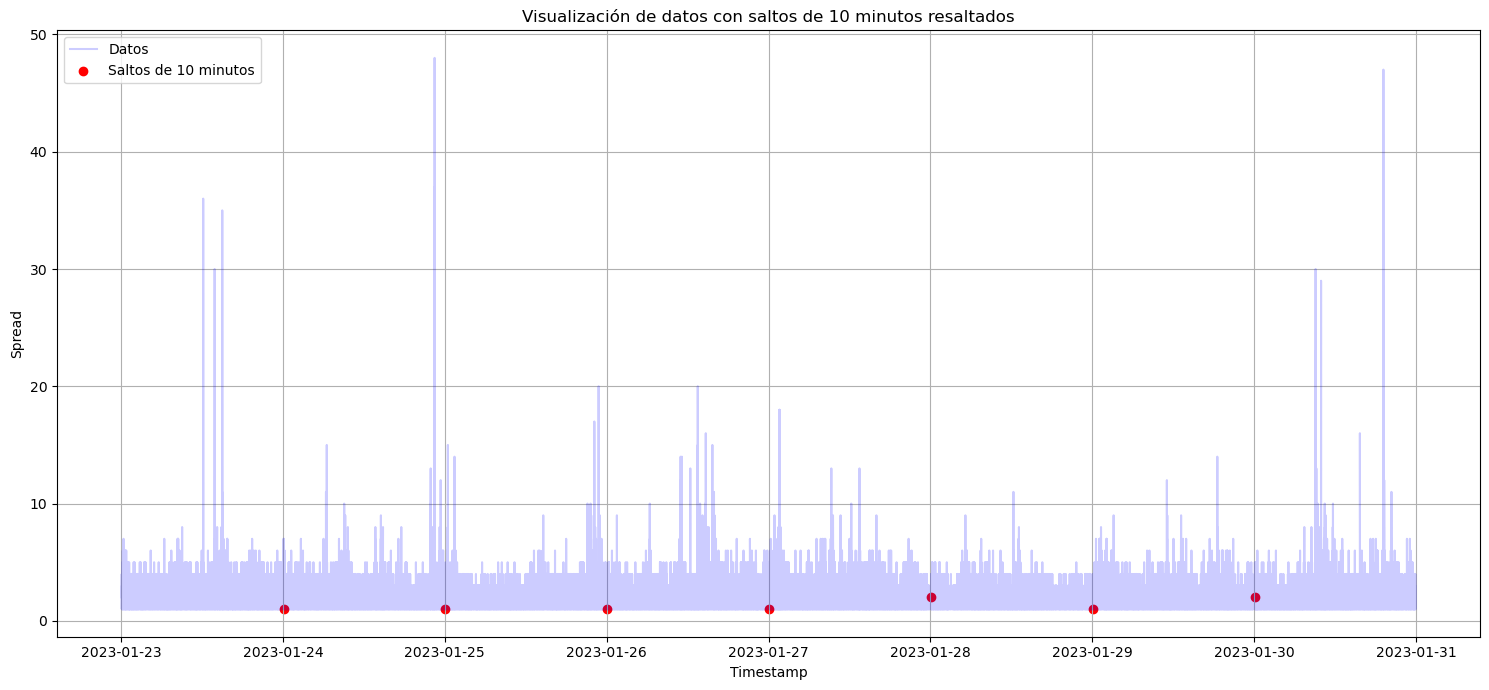

In [524]:
# Asegurarse de que los datos estén ordenados por timestamp:
df = df_train.reset_index().sort_values(by='timestamp')

# Calcular la diferencia entre timestamps consecutivos:
df['time_diff'] = df['timestamp'].diff()

# Identificar los puntos de interés:
mask = df['time_diff'].abs().between(pd.Timedelta('9 minutes 50 seconds'), pd.Timedelta('10 minutes 10 seconds'))

# Graficar los datos:
plt.figure(figsize=(15, 7))
plt.plot(df['timestamp'], df['spread'], label='Datos', color='blue', alpha=0.2)
plt.scatter(df[mask]['timestamp'], df[mask]['spread'], color='red', label='Saltos de 10 minutos')
plt.xlabel('Timestamp')
plt.ylabel('Spread')
plt.title('Visualización de datos con saltos de 10 minutos resaltados')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [525]:
# Calcular la diferencia entre timestamps consecutivos:
df['time_diff'] = df['timestamp'].diff()

# Identificar los puntos de interés:
mask = df['time_diff'].abs().between(pd.Timedelta('9 minutes 50 seconds'), pd.Timedelta('10 minutes 10 seconds'))

# Crear una máscara para los puntos inmediatamente posteriores:
next_mask = mask.shift(-1, fill_value=False)

# Combinar las dos máscaras usando el operador "or":
combined_mask = mask | next_mask

# Extraer estos puntos en un nuevo DataFrame:
df_10min_timeskips = df[combined_mask].copy()

df_10min_timeskips.sort_values('timestamp', ascending=True, inplace=True)
df_10min_timeskips.set_index('timestamp', inplace=True)

print(df_10min_timeskips.index)


DatetimeIndex(['2023-01-23 23:54:59.459493120',
               '2023-01-24 00:05:00.602287104',
               '2023-01-24 23:54:59.469715200',
               '2023-01-25 00:05:00.563300864',
               '2023-01-25 23:54:59.934701568',
               '2023-01-26 00:05:00.664434944',
               '2023-01-26 23:54:59.788566016',
               '2023-01-27 00:05:00.626959872',
               '2023-01-27 23:54:59.901041408',
               '2023-01-28 00:05:00.773246976',
               '2023-01-28 23:54:59.843753472',
               '2023-01-29 00:05:00.646789376',
               '2023-01-29 23:54:59.372211712',
               '2023-01-30 00:05:00.780386048'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


Los saltos temporales de 10 minutos ocurren cada vez entre las `23:55:00` y las `00:05:00`. Esto puede tratarse a cierres temporales programados en el sistema de recolección de datos.

In [526]:
# Eliminamos valores atípicos:
df_train = remove_outliers(df_train, multiplier=1.5) # Mejor multiplicador: 1.5

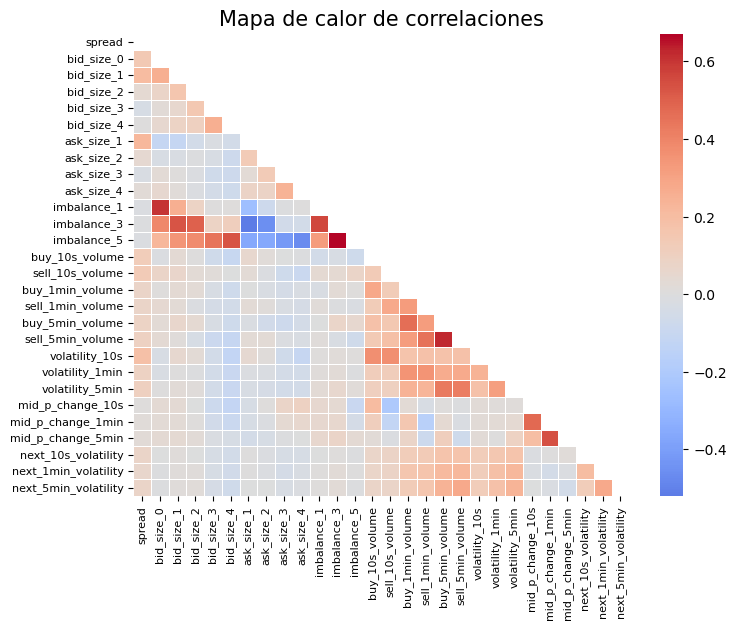

In [527]:
# Mapa de calor
corr = df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=False)
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig('images/heatmap_more_data.png', dpi='figure')
plt.show()

# # Leer la imagen del archivo
# img = mpimg.imread('images/heatmap_more_data.png')
# plt.figure(figsize=(10,10))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

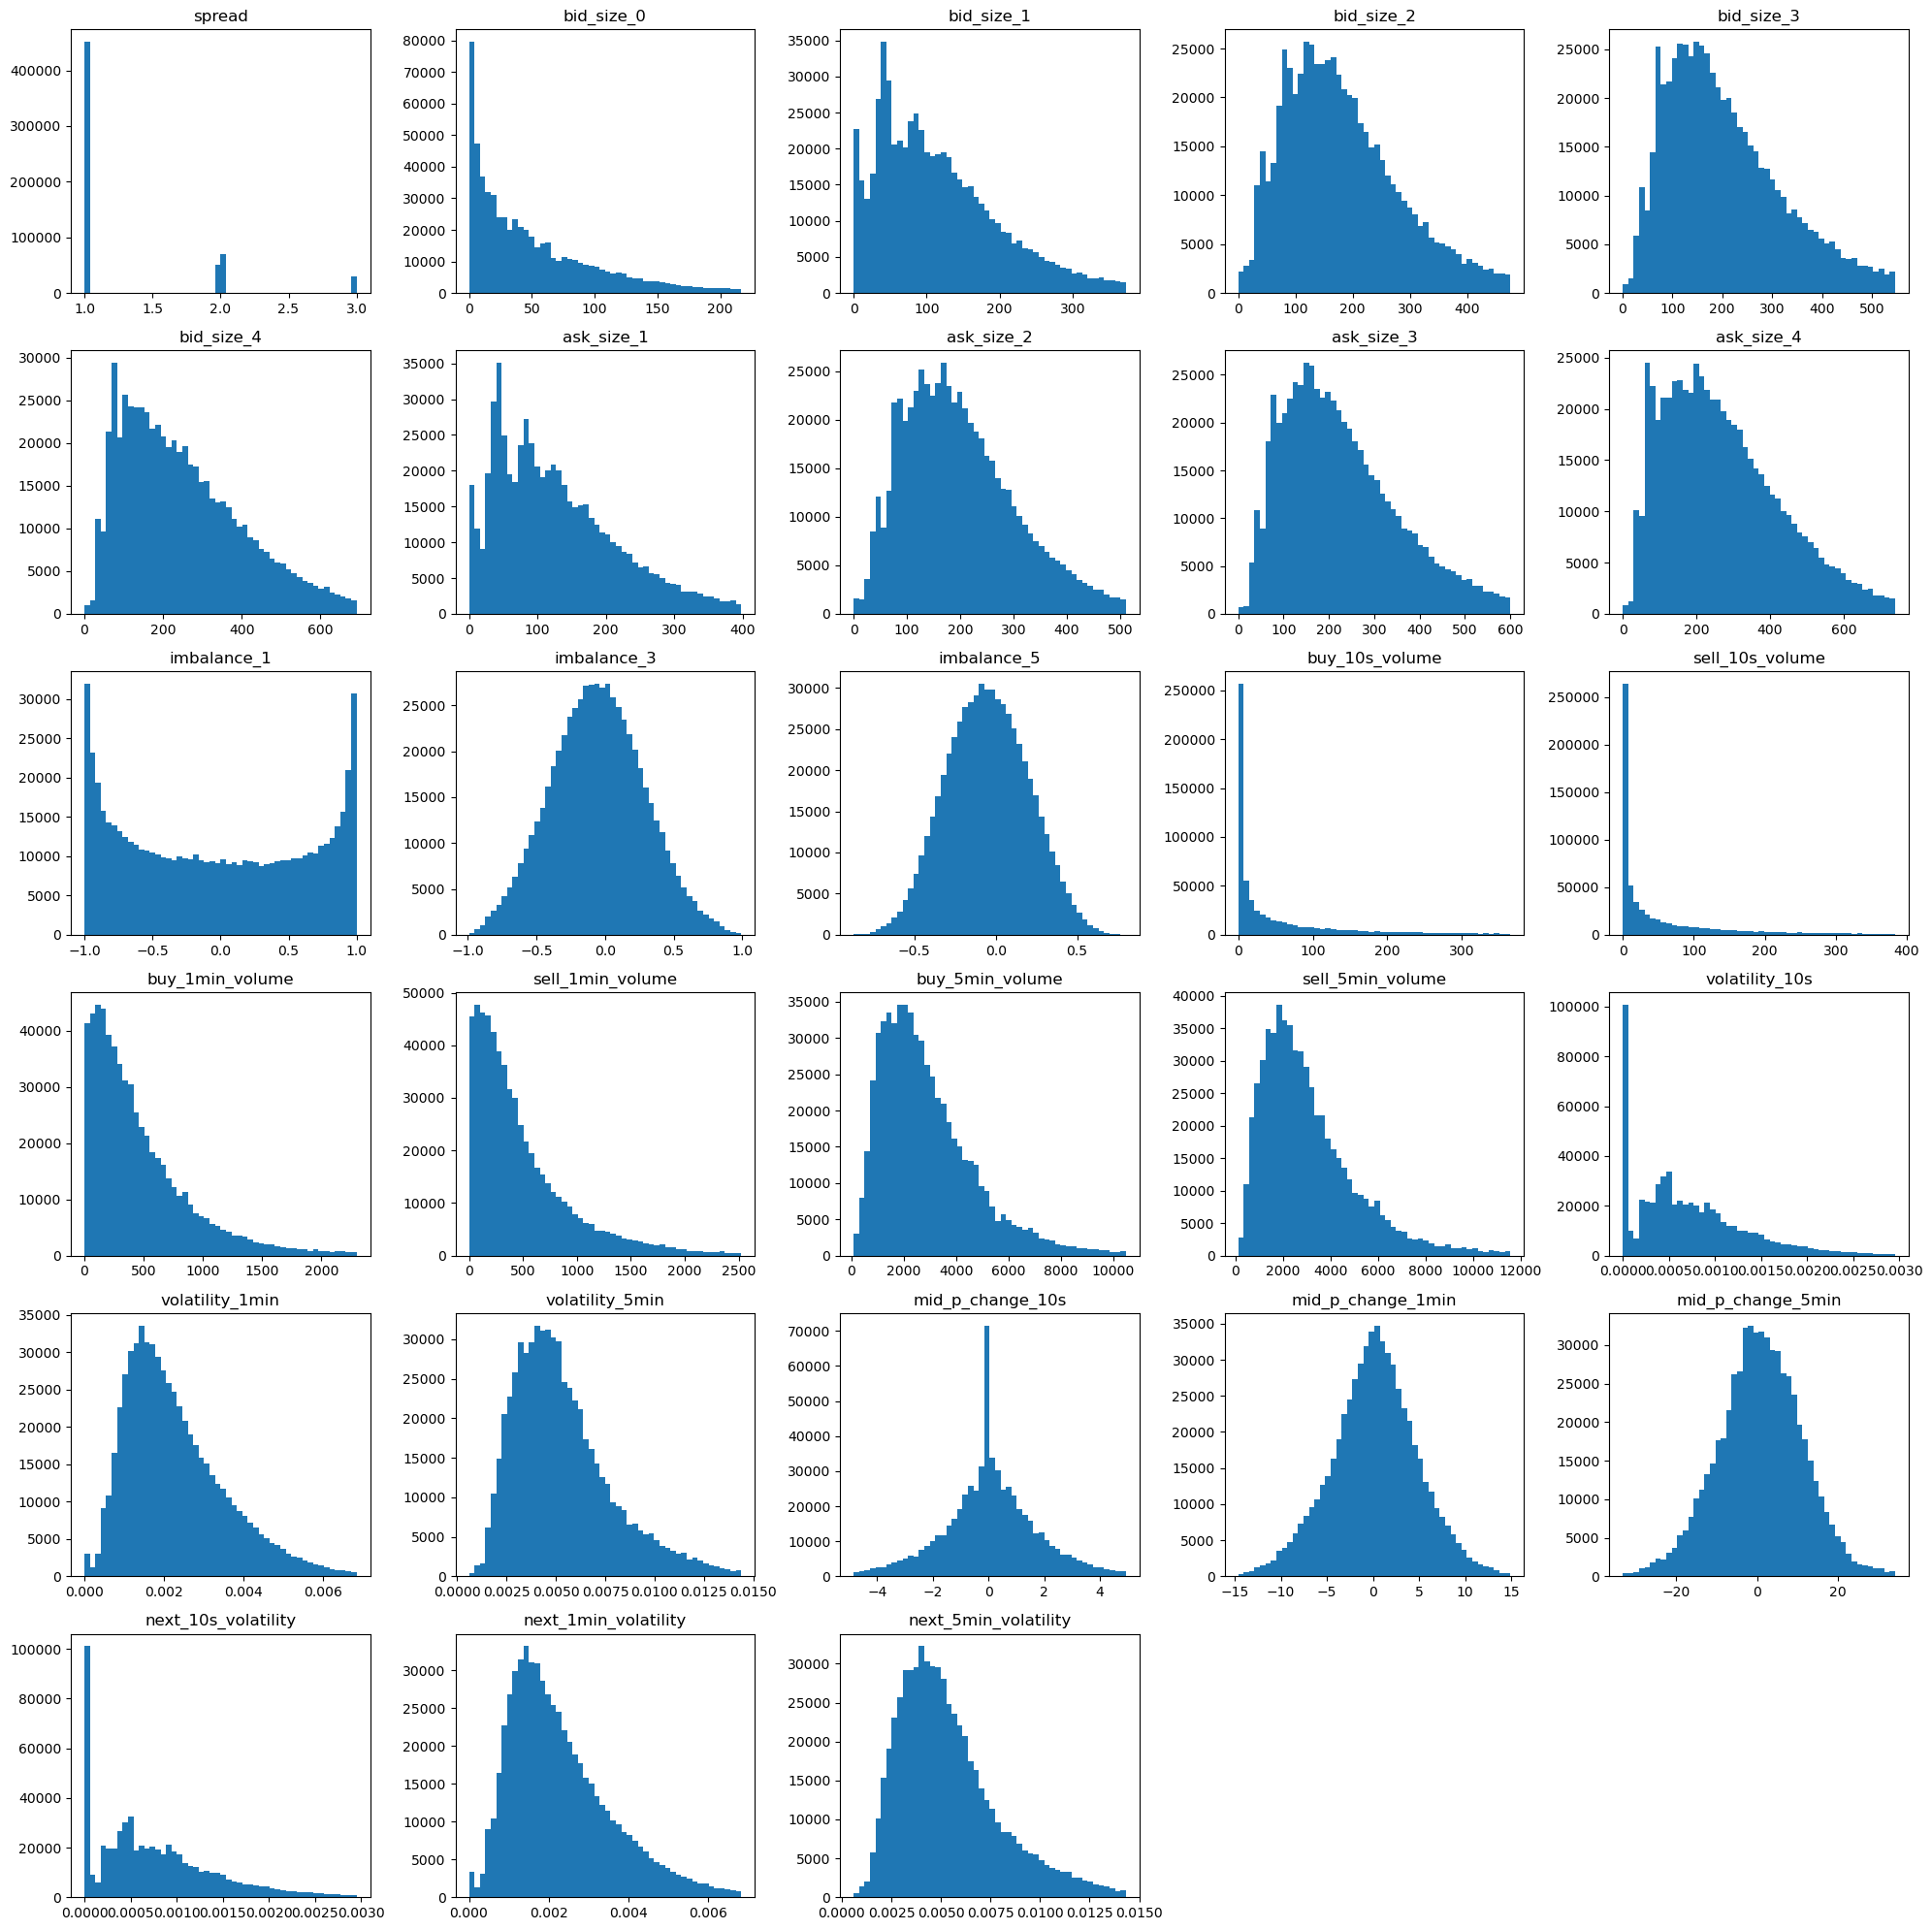

In [528]:
# Plotear histogramas de cada variable:
df_train.hist(figsize=(20, 20), bins=50, grid=False)
plt.tight_layout()
plt.savefig('images/hists_more_data.png', dpi='figure')
plt.show()

# # Leer la imagen del archivo
# img = mpimg.imread('images/hists_more_data.png')
# plt.figure(figsize=(15,15))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

### Tests estadísticos para la distribución de la variable objetivo

In [529]:
import scipy.stats as stats

Y = df_train['mid_p_change_10s']

# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(Y)
print(f"Shapiro-Wilk Statistic: {shapiro_stat}, p-value: {shapiro_p}")

# Kurtosis y Asimetría
kurtosis_val = stats.kurtosis(Y)
skewness_val = stats.skew(Y)
print(f"Kurtosis: {kurtosis_val}")
print(f"Skewness: {skewness_val}")

# Test de Anderson-Darling
anderson_result = stats.anderson(Y)
print(f"Anderson-Darling Statistic: {anderson_result.statistic}")
for i in range(len(anderson_result.critical_values)):
    sl, cv = anderson_result.significance_level[i], anderson_result.critical_values[i]
    if anderson_result.statistic < cv:
        print(f"Significance Level: {sl}, Critical Value: {cv} - Data looks normal")
    else:
        print(f"Significance Level: {sl}, Critical Value: {cv} - Data does not look normal")

Shapiro-Wilk Statistic: 0.9877957105636597, p-value: 0.0
Kurtosis: 0.4638713216331709
Skewness: -0.006635283203639369
Anderson-Darling Statistic: 2909.9961843432393
Significance Level: 15.0, Critical Value: 0.576 - Data does not look normal
Significance Level: 10.0, Critical Value: 0.656 - Data does not look normal
Significance Level: 5.0, Critical Value: 0.787 - Data does not look normal
Significance Level: 2.5, Critical Value: 0.918 - Data does not look normal
Significance Level: 1.0, Critical Value: 1.092 - Data does not look normal


c:\Users\ivan_\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


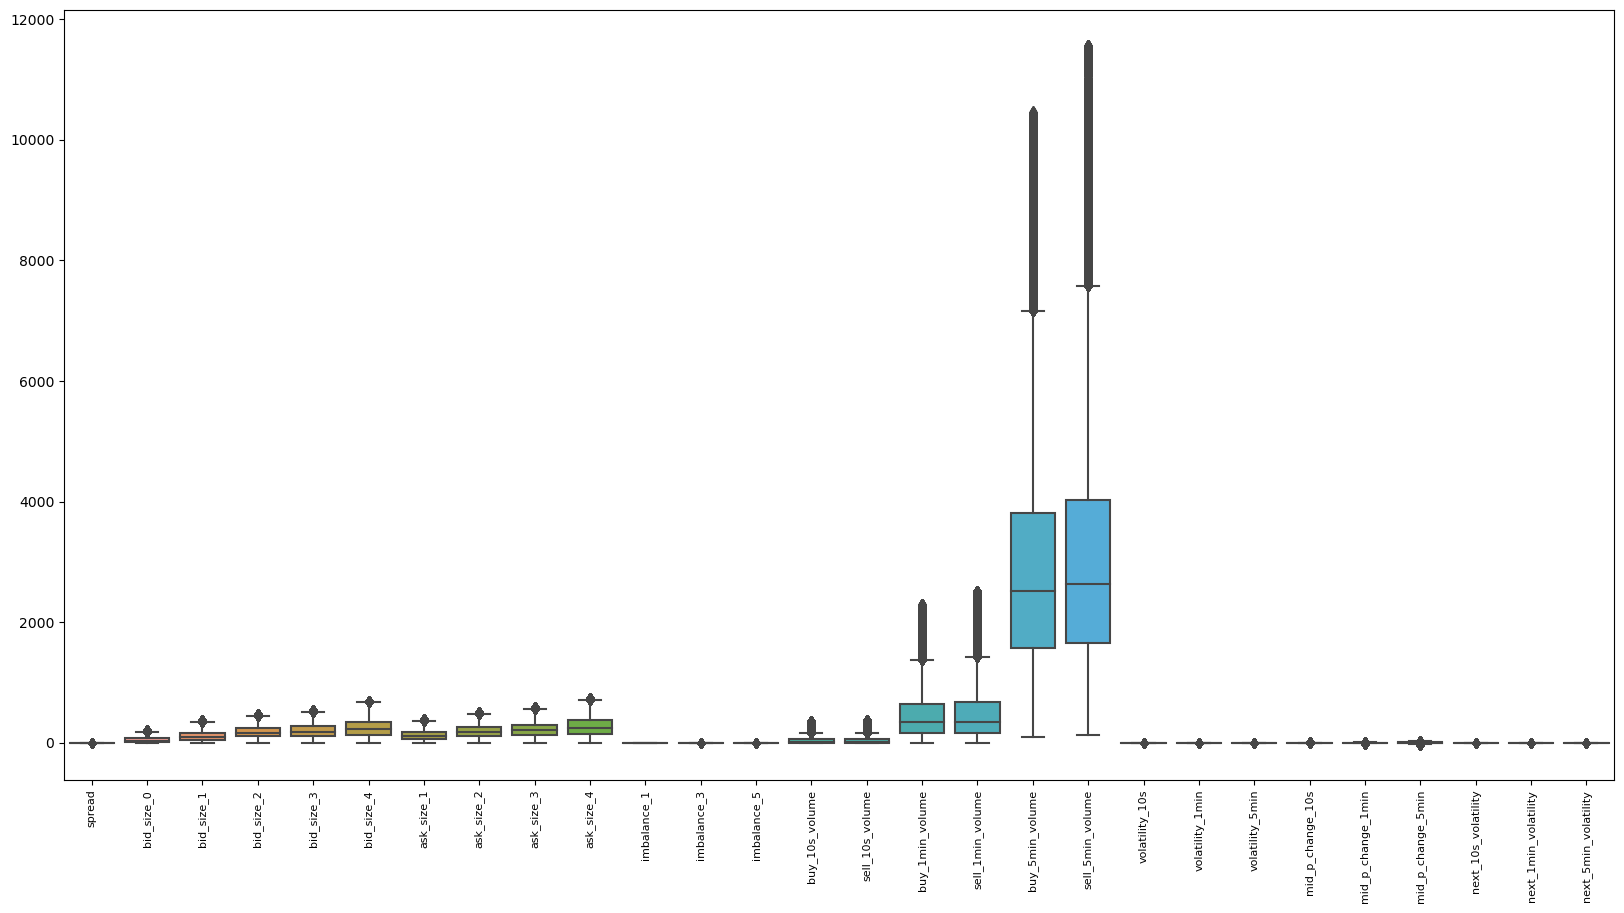

In [530]:
# Boxplots
plt.figure(figsize=(20, 10))
sns.boxplot(df_train)
plt.xticks(fontsize=8, rotation=90)
plt.savefig('images/boxplots_more_data.png', dpi='figure')
plt.show()

# # Leer la imagen del archivo
# img = mpimg.imread('images/boxplots_more_data.png')
# plt.figure(figsize=(15,10))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

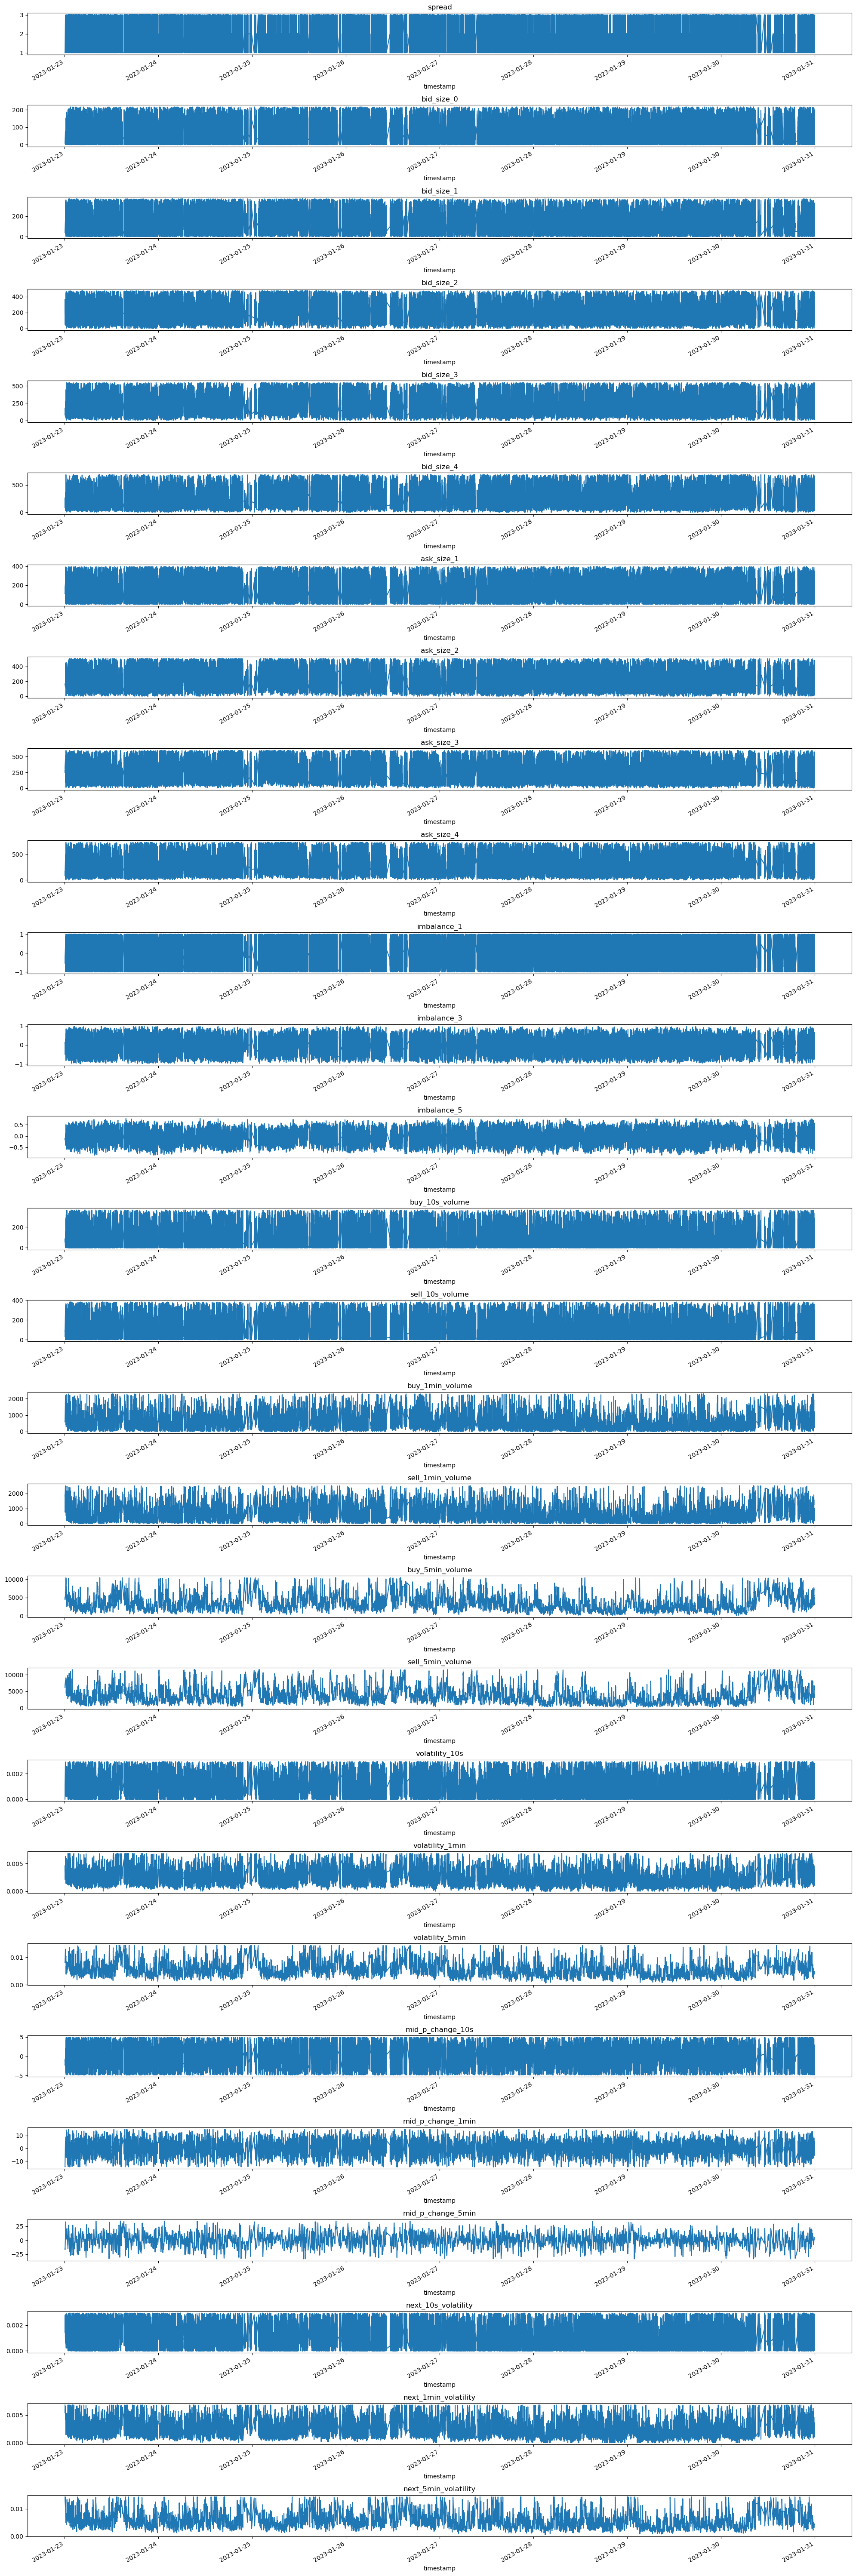

In [531]:
# Plotear líneas de cada variable:
fig, axs = plt.subplots(len(df_train.columns), 1, figsize=(20, 60))
for i, col in enumerate(df_train.columns):
    df_train[col].plot(ax=axs[i], title=col)
plt.tight_layout()
plt.savefig('images/lineplots.png', dpi='figure')
plt.show()

# # Leer la imagen del archivo
# img = mpimg.imread('images/lineplots.png')
# plt.figure(figsize=(15,45))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

# Creación de nuevas características

In [532]:
# Medias Móviles
for col in ['spread', 'buy_10s_volume', 'sell_10s_volume']:
    for window in [10, 50, 200]:
        df_train[f'{col}_ma_{window}'] = df_train[col].rolling(window=window).mean()

# Momento
df_train['momentum'] = df_train['spread'] - df_train['spread'].shift(10)

# Rango Verdadero Medio (ATR):
df_train['tr'] = df_train['spread'].rolling(window=14).apply(lambda x: max(x[-1] - x[0], abs(x[-1] - x.min()), abs(x[-1] - x.max())))
df_train['atr'] = df_train['tr'].rolling(window=14).mean()

# Cambio en el Desbalance
df_train['imbalance_1_change'] = df_train['imbalance_1'].diff()
df_train['imbalance_3_change'] = df_train['imbalance_3'].diff()
df_train['imbalance_5_change'] = df_train['imbalance_5'].diff()

# Relación Volumen de Compra/Venta. Nota: El divisor suma 1 para evitar valores infinitos.
df_train['log_buy_sell_volume_ratio_10s'] = np.log(df_train['buy_10s_volume'] / (df_train['sell_10s_volume'] + 1) + 1)
df_train['log_buy_sell_volume_ratio_1min'] = np.log(df_train['buy_1min_volume'] / (df_train['sell_1min_volume'] + 1) + 1)
df_train['log_buy_sell_volume_ratio_5min'] = np.log(df_train['buy_5min_volume'] / (df_train['sell_5min_volume'] + 1) + 1)

# Características Lag, creadas según lo observado en los gráficos de ACF y PACF:
for col in ['spread', 'imbalance_1', 'imbalance_3', 'imbalance_5']:
        df_train[f'{col}_lag_1'] = df_train[col].shift(1)

# Características de Interacción:
df_train['spread_imbalance1'] = df_train['spread'] * df_train['imbalance_1']

# Puntuación estándar para ventanas de corto (100), medio (500) y largo (3000) plazo. Nota: El divisor suma 1 para evitar valores infinitos.
df_train['z_score_spread_100'] = (df_train['spread'] - df_train['spread'].rolling(window=100).mean()) / (df_train['spread'].rolling(window=100).std() + 1)
df_train['z_score_spread_500'] = (df_train['spread'] - df_train['spread'].rolling(window=500).mean()) / (df_train['spread'].rolling(window=500).std() + 1)
df_train['z_score_spread_3000'] = (df_train['spread'] - df_train['spread'].rolling(window=3000).mean()) / (df_train['spread'].rolling(window=3000).std() + 1) 

# Variable "bid" acumulativa.
df_train['bid_total_size'] = df_train[['bid_size_0', 'bid_size_1', 'bid_size_2', 'bid_size_3', 'bid_size_4']].sum(axis=1)
df_train.drop(columns=['bid_size_0', 'bid_size_1', 'bid_size_2', 'bid_size_3', 'bid_size_4'], inplace=True)

# Variable "ask" acumulativa.
df_train['ask_total_size'] = df_train[['ask_size_1', 'ask_size_2', 'ask_size_3', 'ask_size_4']].sum(axis=1)
df_train.drop(columns=['ask_size_1', 'ask_size_2', 'ask_size_3', 'ask_size_4'], inplace=True)

# Relación Bid/Ask
df_train['bid_ask_ratio'] = df_train['bid_total_size'] / df_train['ask_total_size']

# Eliminar las filas con NaN generadas por las operaciones de rolling y diff
df_train.dropna(inplace=True)

# Selección de características

### 1. Multicolinealidad

Para detectar posible multicolinealidad entre las variables características, utilizamos el factor de inflación de la varianza (VIF). 

In [533]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

Y_list = ["mid_p_change_10s", "mid_p_change_1min", "mid_p_change_5min", 
          "next_10s_volatility", "next_1min_volatility", "next_5min_volatility"]

# Y = df_train[Y_list]
Y = df_train["mid_p_change_10s"]

# Definimos la variable objetivo y variables características escaladas 
X = df_train.drop(columns=Y_list)

# # VIF dataframe
# vif_data_more_data = pd.DataFrame()
# vif_data_more_data["feature"] = X.columns

# # Calculamos VIF para cada variable característica:
# vif_data_more_data["VIF"] = [variance_inflation_factor(X.values, i)
#                    for i
#                    in range(len(X.columns))]

# Almacenar el DataFrame como csv: 
# vif_data_more_data.to_csv('eda/vif_data_more_data.csv')

In [534]:
# Importar datos de VIF:
# vif_data_more_data = pd.read_csv('eda/vif_data_more_data.csv', index_col=0)
# vif_data_more_data = vif_data_more_data.sort_values(by="VIF").reset_index()

# Imprimir VIF:
# vif_data_more_data

Hay varias características con multicolinealidad elevada (mayores a 5). También haya variables con multicolinealidad infinita, lo que significa que pueden ser representadas como combinaciones lineales de otras variables. Esto tiene sentido, porque utilizamos las variables originales para crear nuevas. Podemos abordar el problema de multicolinealidad con don enfoques:

1. Eliminar variables con alta multicolinealidad, de mayores a menores y una por una, hasta que tengamos un subconjunto de variables con baja multicolinealidad. Para lograr este enfoque de fuerza bruta, creamos la función `drop_high_vif_vars()`. Si bien esta función elimina variables de forma automática e iterativa, es necesario considerar que puede haber variables eliminadas que sí puedan ser un aporte al modelo, por lo que es necesario utilizarla con cautela.

2. Utilizar modelos de regularización Lasso y Ridge para penalizar ,los coeficientes de variables con alta multicolinealidad.

In [535]:
# # Extraer variables con VIF elevado:
# low_vif_df, high_vif_features_list = drop_high_vif_vars(X)

# # Lista resultante:
# high_vif_features_list

### 2. OLS robusto

Por el momento, diseñaremos un modelo OLS robusto con únicamente para la variable objetivo `mid_p_change_10s`. Incorporar este modelo regresivo en el análisis exploratorio nos permitirá:

1. Inspeccionar variables sin efecto estadísticamente significativo estadística sobre la variable objetivo. La función `feature_backward_elimination()` fue creada con este propósito.
2. Retiradas las variables sin efecto significativo y también las que tienen alta multicolinealidad según `high_vif_features_list`, el OLS inspeccionar otros posibles problemas de multicolinealidad. 

In [536]:
# # Obtener la variable característica:
# y = df_train["mid_p_change_10s"]

# low_multicolineality_X = X.drop(columns=high_vif_features_list)

# features, excluded_features, model = feature_backward_elimination(low_multicolineality_X, y)

# print("Variables sin significancia estadística sobre 'mid_p_change_10s': ", excluded_features)

In [537]:
# print(model.summary())

**Conclusiones del modelo de OLS robusto:**

1. Las variables no significativas para `mid_p_change_10s`, según el modelo OLS robusto son: `bid_size_0`, `bid_size_1`, `bid_size_3`, `sell_1min_volume`, `buy_5min_volume`, `ask_size_3`.
2. El modelo tiene un ajuste relativamente bajo, con un R-squared de 0.15. Esto significa que el modelo explica el 15% de la variabilidad de `mid_p_change_10s`. el R-squared ajustado también es 0.15, lo que indica que la inclusión de las variables en el modelo es adecuada.
3. Los valores de Omnibus, Durbin-Watson y Jarque-Bera evidencian de que los residuos no siguen una distribución normal y hay autocorrelación en los residuos. Esto significa que el modelo está sesgado.
4. El alto valor de condición sugiere que podría haber problemas de multicolinealidad en el modelo.

### Regularización Lasso y Ridge

Para lidiar con los problemas de selección de variables y alta multicolinealidad de los datos, ajustaremos modelos de regularización Lasso y Ridge. Lasso y Ridge son técnicas de regularización para la regresión. Lasso selecciona características al hacer que algunos coeficientes sean cero, simplificando el modelo, mientras que Ridge aborda la multicolinealidad al penalizar el tamaño de los coeficientes. Ambas técnicas buscan prevenir el sobreajuste y mejorar la robustez del modelo, especialmente en presencia de muchas variables predictoras.

In [538]:
from sklearn.preprocessing import StandardScaler

# Escalamos las características con la clase StandardScaler()
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train)
df_train_scaled = pd.DataFrame(
    df_train_scaled,
    columns=scaler.get_feature_names_out(df_train.columns)
    )

In [539]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Definimos la variable objetivo y variables características escaladas:
X_scaled = df_train_scaled.drop(columns=Y_list)
Y_scaled = df_train_scaled["mid_p_change_10s"]

# Dividimos los datos en conjuntos de entrenamiento y prueba:

# Definir el tamaño del conjunto de entrenamiento
train_size = int(len(X) * 0.8)

# Dividir los datos
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = Y_scaled[:train_size], Y_scaled[train_size:]

# Entrenamos el modelo Lasso
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

# Entrenamos el modelo Ridge
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)

print("Modelo Lasso: ", lasso_mse)
print("Modelo Ridge: ", ridge_mse)

Modelo Lasso:  0.9260747805709535
Modelo Ridge:  0.7978330800851882


In [540]:
from sklearn.linear_model import LassoCV

# Definimos una lista de alphas para probar
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Creamos el modelo LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=5000)

# Ajustamos el modelo LassoCV a los datos escalados
lasso_cv.fit(X_train, y_train)

# Obtenemos el alpha óptimo para Lasso
optimal_alpha_lasso = lasso_cv.alpha_
print("Alpha óptimo para Lasso:", optimal_alpha_lasso)

# Ajustar el modelo Lasso con el alpha óptimo
lasso_opt = Lasso(alpha=optimal_alpha_lasso)
lasso_opt.fit(X_scaled, Y_scaled)

# Predecimos con el modelo Lasso:
lasso_predictions = lasso_opt.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("MSE Lasso: ", lasso_mse)


Alpha óptimo para Lasso: 0.001
MSE Lasso:  0.7945922215144082


In [541]:
from sklearn.linear_model import RidgeCV

# Creamos el modelo RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Ajustamos el modelo RidgeCV a los datos escalados
ridge_cv.fit(X_train, y_train)

# Obtenemos el alpha óptimo para Ridge
optimal_alpha_ridge = ridge_cv.alpha_
print("Alpha óptimo para Ridge:", optimal_alpha_ridge)

# Ajustamos el modelo Ridge con el alpha óptimo
ridge_opt = Ridge(alpha=optimal_alpha_ridge)
ridge_opt.fit(X_scaled, Y_scaled)

# Predecimos con el modelo Ridge:
ridge_predictions = ridge_opt.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print("MSE Ridge: ", ridge_mse)

Alpha óptimo para Ridge: 100.0
MSE Ridge:  0.7946141789927068


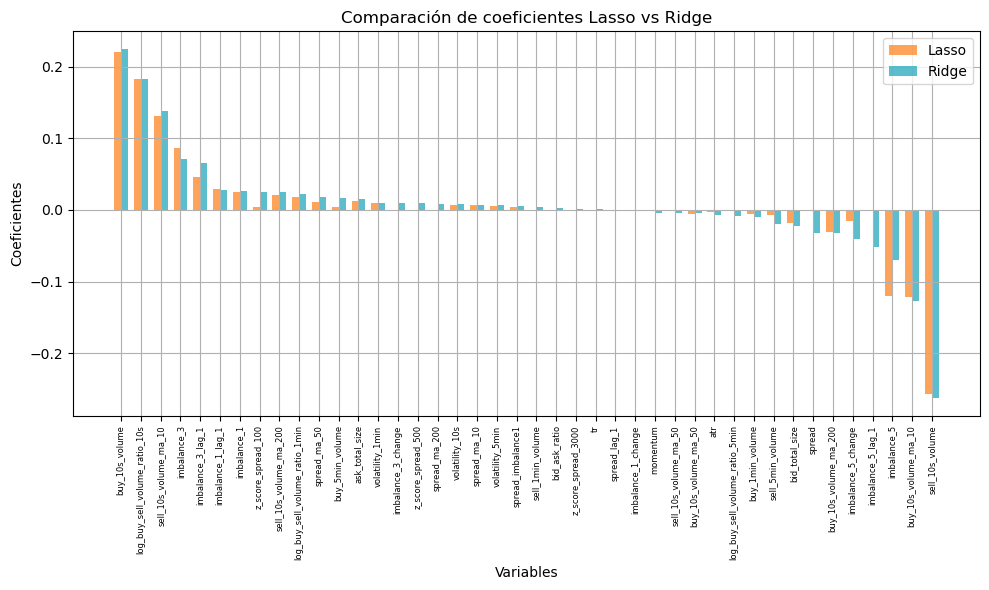

In [542]:
# Creamos un DataFrame con los coeficientes Lasso y Ridge:
regularization_coefs = pd.DataFrame(
    {'X': X_scaled.columns, 
    'lasso_coefs': lasso_opt.coef_,
    'ridge_coefs': ridge_opt.coef_}
    )

# Ordenamos el DataFrame según los coeficientes de Lasso (o Ridge) en orden descendente:
regularization_coefs = regularization_coefs.sort_values(by='ridge_coefs', ascending=False)

# Creamos un gráfico de barras comparativo:
bar_width = 0.35
index = np.arange(len(regularization_coefs['X']))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, regularization_coefs['lasso_coefs'], bar_width, label='Lasso', color='#fd7e14', alpha=0.7)
bar2 = ax.bar(index + bar_width, regularization_coefs['ridge_coefs'], bar_width, label='Ridge', color='#17a2b8', alpha=0.7)

ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.set_title('Comparación de coeficientes Lasso vs Ridge')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(regularization_coefs['X'], rotation=90, fontsize=6)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

En los resultados previos, observamos que:

1. Los valores de MSE de ambos modelos son muy cercanos.
2. Tanto Lasso como Ridge tienen valores de coeficientes similares.
3. Existen variables con coeficientes muy pequeños. Caso especial el de la variable `ask_size_0`, que fue totalmente eliminada por el modelo Lasso. Esto es consistente con la prueba de multicolinealidad VIF y con el procedimiento de eliminación de variables con OLS robusto.

Con estos resultados en mente consideramos dos escenarios:

1. Si buscamos un modelo más simple y parsimonioso que solo incluya las variables más críticas, Lasso podría ser la mejor opción. Es especialmente útil si exiten que hay variables irrelevantes o redundantes en los datos.

2. Por otra parte, Si consideramos que todas las variables pueden tener algún grado de importancia y queremos un modelo que tenga en cuenta la multicolinealidad, Ridge podría ser más adecuado.

Para ambos casos y con base en los valores de los coeficientes Lasso y Ridge, podríamos definir un umbral de eliminación de variables adecuado. Dicho esto, **la elección final también debe basarse en el rendimiento predictivo**.

### 2.3 Análisis de Componentes Principales

Núm. de componentes principales que acumulan 99.0% de varianza:  6


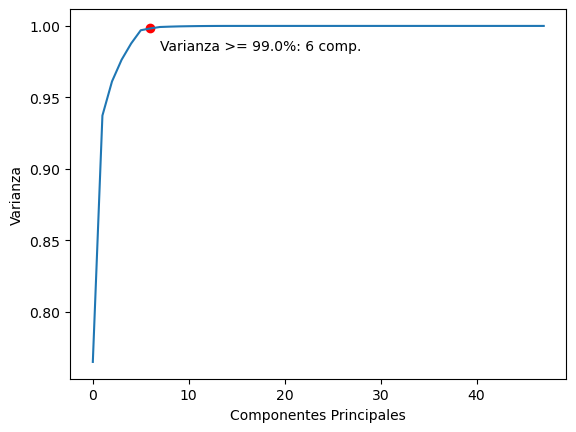

In [543]:
from sklearn.decomposition import PCA

# Instanciamos, ajustamos, transformamos y obtenemos el ratio de varianza explicada:
pca = PCA()
Xtrain_pca = pca.fit_transform(df_train)
exp_variance = pca.explained_variance_ratio_

# Número mínimo de componentes principales que acumulan al menos un valor requerido de varianza:

requested_variance = 0.99
exp_variance_cum_sum = np.cumsum(exp_variance)
n_components = min(np.where(exp_variance_cum_sum >= requested_variance)[0][0] + 1, len(exp_variance_cum_sum) - 1)
#n_components = np.where(exp_variance_cum_sum >= requested_variance)[0][0] + 1
print(f"Núm. de componentes principales que acumulan {requested_variance * 100}% de varianza: ", n_components)

# Graficamos:
plt.plot(exp_variance_cum_sum)
plt.scatter(n_components, exp_variance_cum_sum[n_components], color='red', marker='o')
plt.text(n_components+1, exp_variance_cum_sum[n_components]-.015, f"Varianza >= {requested_variance * 100}%: {n_components} comp.", fontsize=10)
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza')
plt.show()

## 2. Estacionareidad

La estacionariedad se refiere a una propiedad de las series de tiempo en la cual las características estadísticas (como la media, la varianza y la estructura de autocorrelación) no cambian con el tiempo. En otras palabras, una serie estacionaria tiene propiedades que son consistentes a lo largo del tiempo.

La estacionariedad es importante en el análisis de series de tiempo porque muchos métodos y modelos estadísticos asumen esta propiedad. Si una serie no es estacionaria, puede llevar a predicciones poco fiables o engañosas. Hacer que una serie sea estacionaria a menudo es un paso esencial antes de modelarla, ya que mejora la precisión y la interpretabilidad de los modelos.

Para evaluar la estacionariedad de una serie de tiempo, utilizamos la prueba de Dickey-Fuller aumentada (ADF). Esta prueba verifica la hipótesis nula (H0) de que una unidad de raíz está presente en una muestra de una serie de tiempo. Si la hipótesis nula se rechaza, se puede inferir que la serie de tiempo es estacionaria. El resultado de la prueba es un valor-p, y si este valor es menor que un nivel de significancia determinado (por ejemplo, 0.05), entonces podemos rechazar H0 y considerar que la serie es estacionaria.

**Dada la gran cantidad de filas en `df_train` y el enorme costo computacional de la prueba, ejecutaremos `adfuller()` en una muestra del 10%.**

La evidencia sugiere que todas las variables son estacionarias. Estas fueron evaluadas en su primer 10% con la prueba de Dickey-Fuller.

In [544]:
from statsmodels.tsa.stattools import adfuller

# # Obtenemos la muestra del conjunto de datos:
# row_sample = int(df_train.shape[0] / 10)
# df_train_sample = df_train.iloc[:row_sample]

# # Ejecutamos adfuller() en cada columna del conjunto de datos y guardamos los valores-p:
# adfuller_p_values = []

# for col in df_train.columns:
#     p_value = adfuller(df_train_sample[col])[1]
#     adfuller_p_values.append(p_value)

# # Creamos un DataFrame que albergue loos valores-p de la prueba:
# adfuller_p_values_df = pd.DataFrame(
#     {'Series': df_train.columns,
#     'adfuller_p_values': adfuller_p_values}
# )
# # Verificamos si los valores-p son inferiores al umbral de significancia:
# adfuller_p_values_df['H0_rejected'] = adfuller_p_values_df['adfuller_p_values'] < 0.05

# # Guardamos los valores-p obtenidos en un archivo csv:
# adfuller_data = adfuller_p_values_df.to_csv('eda/adfuller_data.csv')

# # Imprimimos:
# adfuller_data = pd.read_csv('eda/adfuller_data.csv', index_col=0)
# adfuller_data

En la muestra tomada, la prueba de Dickey-Fuller aumentada fuertemente sugiere que las todas series son estacionarias. Este es un dato importante previo al modelado y predicción de los datos. Sin embargo, es necesario actuar con cautela, puesto que carecemos de certeza si los datos se mantienen estacionarios en todo su espacio temporal.

### Autocorrelación

In [545]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Número de variables
# n_vars = df_train_sample.shape[1]

# # Creamos una cuadrícula de subgráficos:
# fig, axes = plt.subplots(nrows=n_vars, ncols=2, figsize=(12, 4*n_vars))

# for i, column in enumerate(df_train_sample.columns):
#     plot_acf(df_train_sample[column], lags=50, alpha=0.05, ax=axes[i, 0], title=f"ACF de {column}")
#     plot_pacf(df_train_sample[column], lags=50, alpha=0.05, ax=axes[i, 1], title=f"PACF de {column}")

# plt.tight_layout()
# plt.savefig('images/acf_pacf_more_data.png', dpi='figure')
# plt.show()

# # Leer la imagen del archivo
# img = mpimg.imread('images/acf_pacf_more_data.png')
# plt.figure(figsize=(20,100))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

## Modelo Long Short-Term Memory (LSTM)

In [546]:
# Utilizar la función filtro de variables con Lasso y Ridge: 
L1L2_X = select_features_from_regularization(
    regularization_coefs, # Matriz de coeficientes de regularización
    lasso_threshold=0.05, # 0.02
    ridge_threshold=0.05 # 0.02
    )

# Revisar las variables seleccionadas:
L1L2_X

['sell_10s_volume_ma_10',
 'buy_10s_volume',
 'log_buy_sell_volume_ratio_10s',
 'imbalance_3',
 'buy_10s_volume_ma_10',
 'sell_10s_volume',
 'imbalance_5']

In [547]:
# Escalar las características
X = df_train[L1L2_X]
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Transformación Yeo-Johnson sobre la variable objetivo. 
# La transformación no mejora sustancialmente la predicción pero ayuda a una convergencia más rápida.
yj_Y, lambda_best_fit = stats.yeojohnson(Y) 

# Escalar las variables objetivo
Y = pd.DataFrame(yj_Y, index=Y.index)
Y_scaler = StandardScaler()
Y_scaled = Y_scaler.fit_transform(Y)
Y_scaled = pd.DataFrame(Y_scaled, columns=Y.columns, index=Y.index)

In [548]:
# One-hot encoding para el día de la semana:
days_encoded = pd.get_dummies(X_scaled.index.dayofweek, prefix='day')

# One-hot encoding para la hora del día:
hours_encoded = pd.get_dummies(X_scaled.index.hour, prefix='hour')

# Asegurarse de que los DataFrames codificados tengan el mismo índice que X_scaled:
days_encoded.index = X_scaled.index
hours_encoded.index = X_scaled.index

# Concatenar las columnas codificadas al DataFrame original
X_scaled = pd.concat([X_scaled, days_encoded, hours_encoded], axis=1)

# Eliminar variables de día y hora de referencia (lunes y hora 0, respectivamente):
X_scaled.drop(columns=['hour_0', 'day_0'], inplace=True)

X_scaled.columns

Index(['sell_10s_volume_ma_10', 'buy_10s_volume',
       'log_buy_sell_volume_ratio_10s', 'imbalance_3', 'buy_10s_volume_ma_10',
       'sell_10s_volume', 'imbalance_5', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [549]:
# Dividir los datos en entrenamiento (85% del total) y prueba (15% del total)
train_size = int(len(X_scaled) * 0.7)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
Y_train, Y_test = Y_scaled[:train_size], Y_scaled[train_size:]

# Invertir el escalado de los datos de prueba a escala original:
Y_test_rescaled = Y_scaler.inverse_transform(Y_test)

# Dividir el conjunto de entrenamiento en entrenamiento (80% de train_size) y validación (20% de train_size)
val_size = int(train_size * 0.7)
X_train, X_val = X_train[:val_size], X_train[val_size:]
Y_train, Y_val = Y_train[:val_size], Y_train[val_size:]

# Cambiar la forma de los datos para LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Definir la cantidad de nodos de entrada y de salida:
window_size = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = Y_scaled.shape[1]

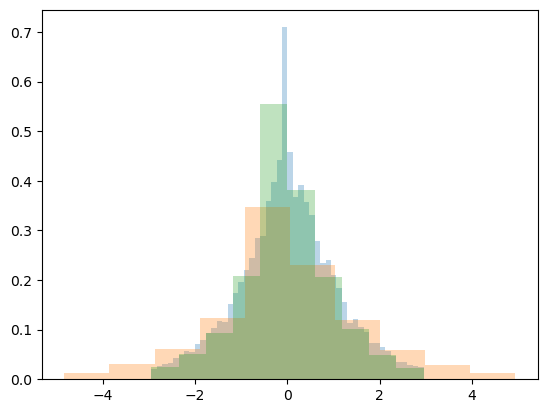

In [550]:
# Visualizar  distribución de variable objetivo:
plt.hist(Y_train, alpha=0.3, bins=50, density=True, label="Y_train")
plt.hist(Y_test_rescaled, alpha=0.3, density=True, label="Y_test")
plt.hist(Y_val, alpha=0.3, density=True, label="Y_val")
plt.show()

In [551]:
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Dropout, BatchNormalization
# from keras.optimizers import Adam

# # Definir optimizador:
# lr = 0.0001
# optimizer = Adam(learning_rate=lr)

# # Dropout generalizado:
# dropout = 0.1 # <-- 0.1

# # Primera capa LSTM:
# lstm_model = Sequential()
# lstm_model.add(
#      LSTM(60,
#           activation='tanh', 
#           input_shape=(window_size, n_features),
#           dropout=dropout,
#           recurrent_dropout=dropout,
#           return_sequences=True  # Esto permite que la salida sea una secuencia, que alimentará la siguiente capa LSTM.
#           )
#      )

# # Segunda capa LSTM:
# lstm_model.add(
#      LSTM(50,
#           activation='tanh',
#           dropout=dropout,
#           recurrent_dropout=dropout
#           )
#      )

# # # Capa de dropout previa a la capa densa:
# # lstm_model.add(Dropout(dropout))

# # Capa densa de salida:
# lstm_model.add(Dense(n_outputs))

# # Compilar el modelo:
# lstm_model.compile(optimizer=optimizer, loss='mse')

In [552]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

# Definir optimizador:
lr = 0.0001
optimizer = Adam(learning_rate=lr)

# Capa LSTM única:
lstm_model = Sequential()
lstm_model.add(
     LSTM(40,  # Reducido el número de unidades
          activation='tanh', 
          input_shape=(window_size, n_features),
          return_sequences=False  # No es necesario ya que no hay una segunda capa LSTM
          )
     )

# Capa densa de salida:
lstm_model.add(Dense(n_outputs))

# Compilar el modelo:
lstm_model.compile(optimizer=optimizer, loss='mse')


In [553]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Definimos la detención temprana:
patience = 5

early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    verbose=1,
    restore_best_weights=True
    )

# Definir el checkpoint del modelo:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
    )
 

# Entrenamos el modelo:
train_history = lstm_model.fit(
    X_train,
    Y_train,
    epochs=50,
    batch_size=72,
    validation_data=(X_val, Y_val),
    verbose=2,
    shuffle=False,
    callbacks=[early_stopper, checkpoint]
    )

Epoch 1/50
4072/4072 - 16s - loss: 0.9869 - val_loss: 0.7831 - 16s/epoch - 4ms/step
Epoch 2/50
4072/4072 - 13s - loss: 0.9417 - val_loss: 0.7763 - 13s/epoch - 3ms/step
Epoch 3/50
4072/4072 - 14s - loss: 0.9326 - val_loss: 0.7745 - 14s/epoch - 3ms/step
Epoch 4/50
4072/4072 - 14s - loss: 0.9293 - val_loss: 0.7735 - 14s/epoch - 3ms/step
Epoch 5/50
4072/4072 - 14s - loss: 0.9276 - val_loss: 0.7727 - 14s/epoch - 3ms/step
Epoch 6/50
4072/4072 - 14s - loss: 0.9264 - val_loss: 0.7722 - 14s/epoch - 3ms/step
Epoch 7/50


KeyboardInterrupt: 

In [ ]:
# import json

# # Guardar el modelo completo en formato HDF5:
# lstm_model.save('trained_models/lstm_model_5.h5')

# # Guardar la historia como JSON:
# with open('trained_models/train_history_5.json', 'w') as file:
#     json.dump(train_history.history, file)

In [ ]:
# Cargar modelo guardado:
lstm_model = load_model('trained_models/lstm_model_5.h5')

# Cargar la historia desde JSON:
with open('trained_models/train_history_5.json', 'r') as file:
    train_history = json.load(file)

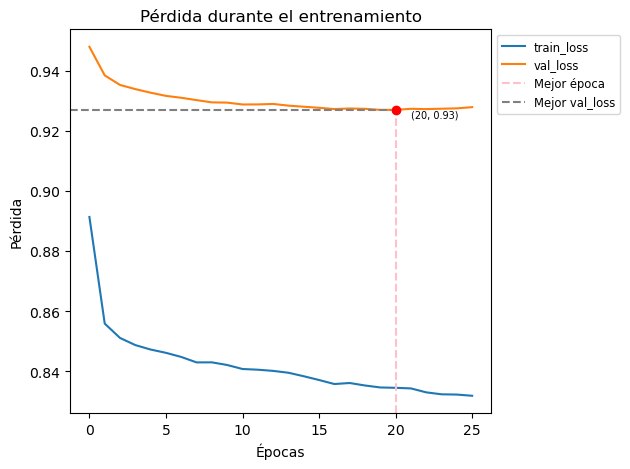

In [ ]:
train_history_df = pd.DataFrame(train_history)

# Plotear los resultados del entrenamiento:
plt.plot(train_history_df['loss'], label='train_loss')
plt.plot(train_history_df['val_loss'], label='val_loss')

# Obtener el índice (época) del mejor valor de pérdida de validación
best_epoch = train_history_df['val_loss'].idxmin()
best_loss = train_history_df['val_loss'].min()

# Agregar líneas punteadas a la coordenada de mejores época y val_loss 
y_ratio = best_loss / plt.ylim()[1]
plt.axvline(x=best_epoch, color='pink', linestyle='--',
            ymax=(best_loss - plt.ylim()[0]) / (plt.ylim()[1] - plt.ylim()[0]), label='Mejor época')
plt.axhline(y=best_loss, color='gray', linestyle='--', xmax=best_epoch/plt.xlim()[1], label='Mejor val_loss')
plt.plot(best_epoch, best_loss, 'ro')

# Mostrar los valores de mejor época y mejor pérdida como coordenadas
plt.text(best_epoch + 1, best_loss, f'({best_epoch}, {best_loss:.2f})',
         color='black', verticalalignment='top', horizontalalignment='left', fontsize=7)

plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# Hacer predicciones
Y_pred = lstm_model.predict(X_test)

# Invertir el escalado para obtener las predicciones en la escala original:
Y_pred = Y_scaler.inverse_transform(Y_pred)

1191/1191 [==============================] - 3s 2ms/step


In [ ]:
# Obtener el MSE de entrenamiento y validación al final del entrenamiento
train_mse = train_history['loss'][-1]
val_mse = train_history['val_loss'][-1]

# MSE en el conjunto de prueba:
test_mse = lstm_model.evaluate(X_test, Y_test_rescaled)

print("RMSE entrenamiento: ", round(train_mse**(0.5), 3))
print("RMSE validación: ", round(val_mse**(0.5), 3))
print("RMSE evaluación:", round(test_mse**(0.5), 3))

# Proporciones sobre entrenamiento:
print("\n")
print("Proporción RMSE entrenamiento: ", round(train_mse**(0.5) / train_mse**(0.5), 3))
print("Proporción RMSE validación: ", round(val_mse**(0.5) / train_mse**(0.5), 3))
print("Proporción RMSE evaluación:", round(test_mse**(0.5) / train_mse**(0.5), 3))

1191/1191 [==============================] - 3s 2ms/step - loss: 2.4125
RMSE entrenamiento:  0.912
RMSE validación:  0.963
RMSE evaluación: 1.553


Proporción RMSE entrenamiento:  1.0
Proporción RMSE validación:  1.056
Proporción RMSE evaluación: 1.703


- RMSE entrenamiento:  0.91
- RMSE validación:  0.963
- RMSE evaluación: 1.563


- Proporción RMSE entrenamiento:  1.0
- Proporción RMSE validación:  1.059
- Proporción RMSE evaluación: 1.718

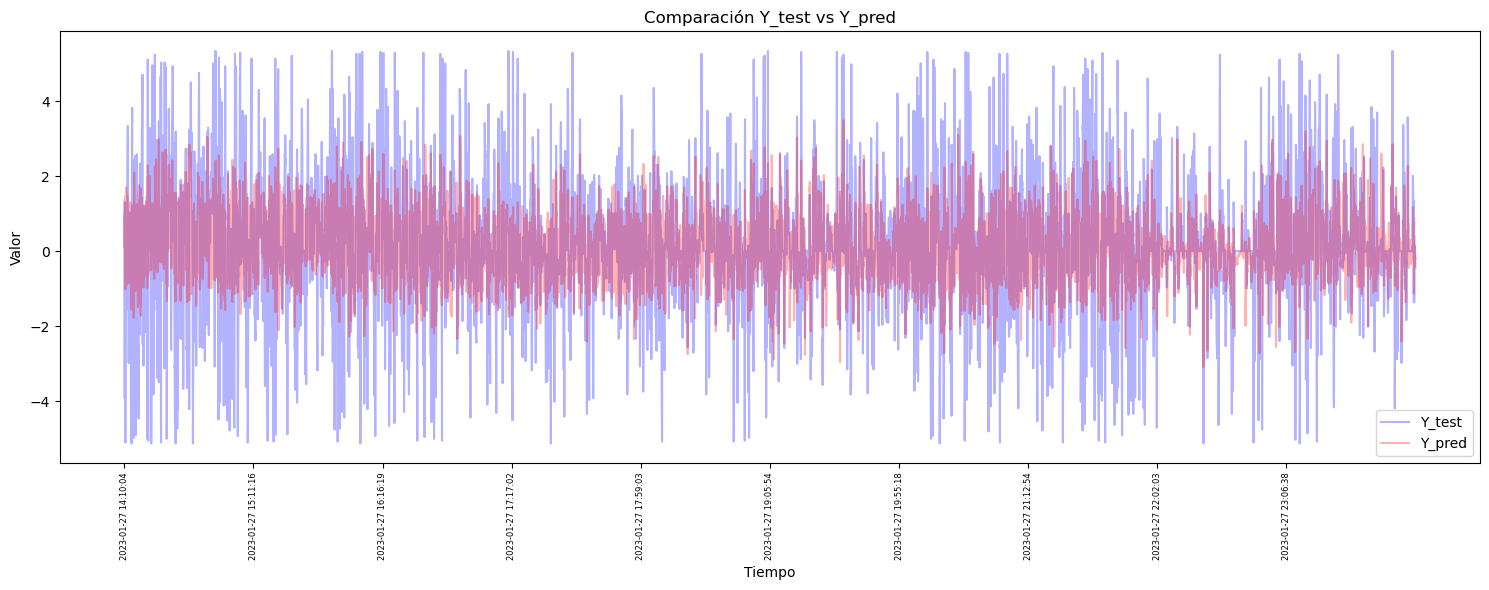

In [ ]:
plt.figure(figsize=(15, 6))

# Graficar los valores reales
plt.plot(Y_test_rescaled, label='Y_test', color='blue', alpha=0.3)

# Graficar las predicciones
plt.plot(Y_pred, label='Y_pred', color='red', alpha=0.3)

# Definir el título y las etiquetas del gráfico
plt.title('Comparación Y_test vs Y_pred')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

# Establecer las etiquetas del eje x usando el índice de tiempo de Y_test
time_labels = Y_test.index.to_list()
positions = list(range(0, len(Y_test_rescaled), len(Y_test_rescaled)//10))  # Tomar 10 puntos equidistantes para las etiquetas
selected_labels = [time_labels[i].strftime('%Y-%m-%d %H:%M:%S') for i in positions]
plt.xticks(positions, selected_labels, rotation=90, size=6)

plt.legend()
plt.tight_layout()
plt.show()